In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import torch
import sklearn
from tensorflow.keras.layers import Input, Dense, Reshape, concatenate
from tensorflow.keras.models import Model

In [2]:
def polar_generator(batchsize,grid=(10,10),noise=.002,flat=False):
  while True:
    x = np.random.rand(batchsize)
    y = np.random.rand(batchsize)
    out = np.zeros((batchsize,grid[0],grid[1]))
    xc = (x*grid[0]).astype(int)
    yc = (y*grid[1]).astype(int)
    for b in range(batchsize):
      out[b,xc[b],yc[b]] = 1
    #compute rho and theta and add some noise
    rho = np.sqrt(x**2+y**2) + np.random.normal(scale=noise)
    theta = np.arctan(y/np.maximum(x,.00001)) + np.random.normal(scale=noise)
    if flat:
      out = np.reshape(out,(batchsize,grid[0]*grid[1]))
    yield ((theta,rho),out)

In [3]:
g1,g2 = 10,10
gen = polar_generator(7500000,grid=(g1,g2),noise=0.002, flat=True)

In [4]:
(theta,rho),maps = next(gen)

df = pd.DataFrame({"angle": theta, "distance": rho, "map": pd.Series(list(maps))})

df.head()

,angle,distance,map
0,0.085740,0.707139,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.160800,0.300832,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.431732,0.961488,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1.548061,0.581501,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,1.469306,0.610416,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [5]:
from sklearn.model_selection import train_test_split

rand = 42

X = df[['angle','distance']].values
y = df['map'].tolist()

# split dataframe into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=rand, shuffle=True )

# Then split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.02, random_state=rand, shuffle=True)

print(f"X_train: {X_train.shape} \nX_test: {X_test.shape}\ny_train: {len(y_train)}\ny_test: {len(y_test)}") 

X_train: (7203000, 2) 
X_test: (150000, 2)
y_train: 7203000
y_test: 150000


In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

tf.config.run_functions_eagerly(True)

def custom_accuracy(target, preds):      
      # Convert predictions to one-hot encoded lists
      eye = tf.eye(g1*g2)
      indexes = tf.argmax(preds, axis=-1)
      pred_maps = tf.cast(tf.gather(eye, indexes, axis=-2),tf.float32)
      
      # Calculate accuracy
      result_array = tf.reduce_all(tf.equal(pred_maps, target), axis = 1)
      correct = tf.reduce_sum(tf.cast(result_array, dtype=tf.int32))
      accuracy = correct.numpy() / tf.shape(result_array)[0].numpy()
      
      return accuracy

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=2, activation='relu'))
    model.add(Dense(8, input_dim=2, activation='relu'))
    model.add(Dense(8, input_dim=2, activation='relu'))
    model.add(Dense(100, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[custom_accuracy])
    return model

model = create_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 4)                 12        
                                                                 
 dense_36 (Dense)            (None, 8)                 40        
                                                                 
 dense_37 (Dense)            (None, 8)                 72        
                                                                 
 dense_38 (Dense)            (None, 100)               900       
                                                                 
Total params: 1,024
Trainable params: 1,024
Non-trainable params: 0
_________________________________________________________________


In [23]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_val = tf.convert_to_tensor(X_train)
y_val = tf.convert_to_tensor(y_train)

history = model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=3, 
          batch_size=256)

Epoch 1/3
28137/28137 [==============================] - 687s 24ms/step - loss: 0.4759 - custom_accuracy: 0.8693 - val_loss: 0.1982 - val_custom_accuracy: 0.9356
Epoch 2/3
28137/28137 [==============================] - 687s 24ms/step - loss: 0.1712 - custom_accuracy: 0.9393 - val_loss: 0.1430 - val_custom_accuracy: 0.9491
Epoch 3/3
28137/28137 [==============================] - 693s 25ms/step - loss: 0.1385 - custom_accuracy: 0.9476 - val_loss: 0.1280 - val_custom_accuracy: 0.9517


In [24]:
# Make predictions on test set
test_predictions = model.predict(X_test)

test_accuracy = custom_accuracy(y_test,test_predictions)

print("Test set accuracy:", test_accuracy)



4688/4688 [==============================] - 12s 3ms/step
Test set accuracy: 0.95094


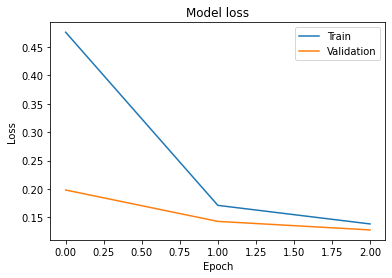

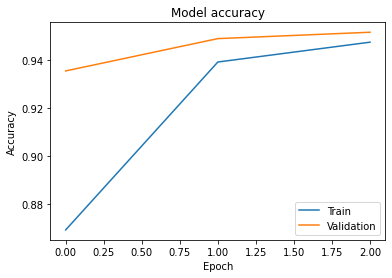

In [25]:
import matplotlib.pyplot as plt

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting training & validation accuracy values
plt.plot(history.history['custom_accuracy'])
plt.plot(history.history['val_custom_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
